In [1]:
from datasets import load_dataset, Image
from torch.utils.data import DataLoader
from mit_semseg.models.resnet import resnet50
from mit_semseg.models import ModelBuilder, SegmentationModule 
import PIL
import torch
import torch.nn as nn
from torch.optim import AdamW
from fastprogress.fastprogress import master_bar, progress_bar
import numpy as np

In [2]:
ade20k_train = load_dataset("scene_parse_150",split='train')
ade20k_valid = load_dataset("scene_parse_150",split='validation')

In [3]:
def prep_dataset(sample):
    img = sample['image']
    label = sample['annotation']
    sample['width'] = img.width
    sample['height'] = img.height

    if (img.mode == 'L') | (img.mode == 'CMYK') | (img.mode == 'RGBA'):
        rgbimg = PIL.Image.new("RGB", img.size)
        rgbimg.paste(img)
        img = rgbimg

    img = img.resize((256,256),resample=PIL.Image.Resampling.LANCZOS)
    # label = label.resize((256,256),resample=PIL.Image.Resampling.NEAREST)
    label = label.resize((32,32),resample=PIL.Image.Resampling.NEAREST)
    
    sample['image'] = Image().encode_example(img)
    sample['annotation'] = Image().encode_example(label)
    return sample

In [4]:
train_dataset = ade20k_train.map(prep_dataset).with_format("torch")
valid_dataset = ade20k_valid.map(prep_dataset).with_format("torch")

In [5]:
encoder = ModelBuilder().build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='').cuda()
decoder = ModelBuilder().build_decoder(
    arch='ppm',
    fc_dim=2048,
    num_class=150,
    weights='',
    use_softmax=False).cuda()
crit = nn.NLLLoss(ignore_index=-1)
optimizer = AdamW(decoder.parameters(), lr=1e-3)

In [6]:
def plot_loss_update(epoch, epochs, mb, train_loss, valid_loss):
    x = range(1, epoch+1)
    y = np.concatenate((train_loss, valid_loss))
    graphs = [[x,train_loss], [x,valid_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

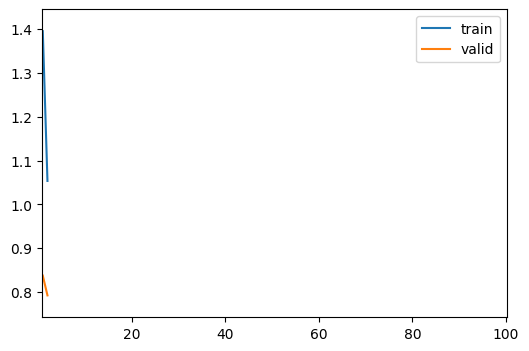

In [ ]:
train_loss, valid_loss = [], []
epochs = 100
mb = master_bar(range(1, epochs+1))
for epoch in mb:
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    for batch in progress_bar(train_dataloader,parent=mb):
        optimizer.zero_grad()
        x = batch['image'].to(torch.float32).permute((0,3,1,2))
        x = (x/255).cuda()
        y = batch['annotation'].to(torch.int64) - 1   
        y = y.cuda()
        ŷ = decoder(encoder(x))
        loss = crit(ŷ,y)
        loss.backward()
        optimizer.step()
    train_loss.append(loss.detach().cpu().item())
    
    valid_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    for batch in progress_bar(valid_dataloader,parent=mb):
        x = batch['image'].to(torch.float32).permute((0,3,1,2))
        x = (x/255).cuda()
        y = batch['annotation'].to(torch.int64) - 1   
        y = y.cuda()
        ŷ = decoder(encoder(x))
        loss = crit(ŷ,y)
    valid_loss.append(loss.detach().cpu().item())
    
    plot_loss_update(epoch, epochs, mb, train_loss, valid_loss)

In [ ]:
torch.save(decoder.state_dict(), f"decoder_weights.pth")